In [1]:
import math
import numpy as np
import time
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
np.random.seed(int(time.time()))

https://towardsdatascience.com/building-your-own-covid-19-epidemic-simple-model-using-python-e39788fbda55

In [353]:
class person:
    def __init__(self, _id,  x, y, v, status, time_infected):
        self.x = x
        self.y = y
        self.v = v
        self.status = status
        self._id = _id 
        self.time_infected = time_infected
    
    def healthy(self):
        self.status = "naive"
    def infect(self):
        self.status = "infected"
    def recover(self):
        self.status = "immune"
        
    def step_x(self, dist):
        self.x += dist
    def step_y(self, dist):
        self.y += dist
        
    def random_walk(self):
        step_x = np.random.random() - 0.5
        step_y = np.random.random() - 0.5
        self.step_x(self.v * step_x)
        self.step_y(self.v * step_y)
    
    def periodic_conditions(self, grid_x, grid_y):
        if self.get_x() < 0:
            self.step_x(grid_x)
        if self.get_x() > grid_x:
            self.step_x(-grid_x)
        if self.get_y() < 0:
            self.step_y(grid_y)
        if self.get_y() > grid_y:
            self.step_y(-grid_y)
        
    def add_time_infected(self, time):
        self.time_infected += time
    
    def get_x(self):
        return self.x
    def get_y(self):
        return self.y
    def get_v(self):
        return self.v
    def get_status(self):
        return self.status
    def get_time_infected(self):
        return self.time_infected
    def _get_id(self):
        return self._id    

helper functions for populations

In [354]:
def healthy_people(list_of_people):
    """returns a list of healthy people"""
    healthy_people = []
    for person in list_of_people:
        if person.status == "naive":
            healthy_people.append(person)
    return healthy_people

def infected_people(list_of_people):
    """returns a list of infected people"""
    infected_people = []
    for person in list_of_people:
        if person.status == "infected":
            infected_people.append(person)
    return infected_people

def immune_people(list_of_people):
    """returns a list of immune people"""
    immune_people = []
    for person in list_of_people:
        if person.status == "immune":
            immune_people.append(person)
    return immune_people

make people

In [355]:
grid_size = 50
grid_x = grid_size
grid_y = grid_size
num_people = 200
print((grid_x * grid_y) / num_people)

12.5


In [356]:
def create_people(num_people, x_max, y_max, num_infected_start = 1):
    list_of_people = []
    infected_people = np.random.randint(0, num_people, num_infected_start)
    for num in range(0, num_people):
        x = np.random.random() * x_max
        y = np.random.random() * y_max
        v = abs(np.random.normal(loc=0.0, scale=2.5, size=None))
        list_of_people.append(person(num, x, y, v, "naive", 0))
    for infection in infected_people:
        list_of_people[infection].infect()
    return list_of_people

move people

In [357]:
def move_people(people, grid_x, grid_y):
    list_of_people = people.copy()
    for person in list_of_people:
        person.random_walk()
        person.periodic_conditions(grid_x, grid_y)
    return list_of_people

In [358]:
def append_population(healthy_population, infected_population, immune_population):
    total_population = []
    for person in healthy_population:
        total_population.append(person)
    for person in infected_population:
        total_population.append(person)
    for person in immune_population:
        total_population.append(person)
    return total_population

infections

In [359]:
def infect_population(people, infection_range = 3):
    list_of_people = people.copy()
    healthy_population = healthy_people(list_of_people)
    infected_population = infected_people(list_of_people)
    immune_population = immune_people(list_of_people)
    
    for person in healthy_population:
        for neighbor in infected_population:
            distance_between = calculate_distance(person.get_x(), neighbor.get_x(), person.get_y(), neighbor.get_y())
            infected = infection_event(distance_between, infection_range)
            if infected:
                person.infect()
                #print(f"infection: {distance_between}")
    
    if len(infected_people(healthy_population)) > 0:
        print(f"newly infected: {len(infected_people(healthy_population))}")
    
    return append_population(healthy_population, infected_population, immune_population)


In [360]:
def infected_to_immune(people, time_to_heal):
    list_of_people = people.copy()
    healthy_population = healthy_people(list_of_people)
    infected_population = infected_people(list_of_people)
    immune_population = immune_people(list_of_people)
    
    for person in infected_population:
        if person.get_time_infected() >= time_to_heal:
            person.recover()
        else:
            person.add_time_infected(1)
            
    return append_population(healthy_population, infected_population, immune_population)

In [361]:
def infection_event(distance_between, infection_range = 3):
    """return 1 if infection occurs, 0 if safe"""
    infected = 0
    if distance_between < infection_range:
        infected = 1
    return infected

In [362]:
def calculate_distance(x1, x2, y1, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [363]:
def collect_data(people):
    list_of_people = people.copy()
    healthy_population = healthy_people(list_of_people)
    infected_population = infected_people(list_of_people)
    immune_population = immune_people(list_of_people)
    
    
    num_healthy = len(healthy_population)
    num_infected = len(infected_population)
    num_immune = len(immune_population)
    
    x_positions = [person.get_x() for person in people]
    y_positions = [person.get_y() for person in people]
    status = [person.get_status() for person in people]
    return num_healthy, num_infected, num_immune, x_positions, y_positions, status

day 0:
 * initialize first infection

In [364]:
try:
    del people
except:
    pass

In [365]:
people = create_people(num_people, grid_x, grid_y)

In [366]:
num_healthy, num_infected, num_immune, x_positions, y_positions, status = collect_data(people)

In [367]:
df_infections = pd.DataFrame()

get number of people healthy/sick/recovered

In [368]:
row_infections = pd.DataFrame([pd.Series([0, num_healthy, num_infected, num_immune])])
df_infections = pd.concat([row_infections, df_infections], ignore_index=True)

get everyone's positions

In [369]:
df_positions_today = pd.DataFrame()

df_positions_today["x_position"] = x_positions
df_positions_today["y_position"] = y_positions
df_positions_today["status"] = status
df_positions_today["day"] = 0

df_positions_today

x_position  y_position status  day
0     45.559443   19.072475  naive    0
1      2.462008   27.001037  naive    0
2     40.532484   40.848680  naive    0
3     13.267225   39.204357  naive    0
4      0.476312   47.890958  naive    0
..          ...         ...    ...  ...
195   19.524709   46.755498  naive    0
196    8.748900   11.373943  naive    0
197   25.080285   38.399511  naive    0
198   28.746861   27.644506  naive    0
199   49.687408    8.551404  naive    0

[200 rows x 4 columns]

later days:
 * move people, then infect

In [370]:
df_positions = df_positions_today.copy()

In [371]:
last_day = 1e4
for day in range(1, 365):
    people = move_people(people, grid_x, grid_y)
    people = infect_population(people, infection_range = 2)
    people = infected_to_immune(people, 14)
    num_healthy, num_infected, num_immune, x_positions, y_positions, status = collect_data(people)
    row_infections = pd.DataFrame([pd.Series([day, num_healthy, num_infected, num_immune])])
    df_infections = pd.concat([row_infections, df_infections], ignore_index=True)
    df_positions_today["x_position"] = x_positions
    df_positions_today["y_position"] = y_positions
    df_positions_today["status"] = status
    df_positions_today["day"] = day
    df_positions = df_positions.append(df_positions_today)
    if num_healthy == 0 or num_infected == 0:
        last_day = day
        break

newly infected: 1
newly infected: 3
newly infected: 3
newly infected: 1
newly infected: 1
newly infected: 1
newly infected: 1
newly infected: 3
newly infected: 1
newly infected: 2
newly infected: 3
newly infected: 1
newly infected: 1
newly infected: 5
newly infected: 1
newly infected: 2
newly infected: 1
newly infected: 1
newly infected: 1
newly infected: 2
newly infected: 3
newly infected: 2
newly infected: 2
newly infected: 1
newly infected: 1
newly infected: 1
newly infected: 1
newly infected: 1
newly infected: 1
newly infected: 4
newly infected: 2
newly infected: 4
newly infected: 4
newly infected: 1
newly infected: 2
newly infected: 3
newly infected: 1
newly infected: 1
newly infected: 2
newly infected: 2
newly infected: 3
newly infected: 2
newly infected: 4
newly infected: 3
newly infected: 5
newly infected: 2
newly infected: 3
newly infected: 4
newly infected: 2
newly infected: 1
newly infected: 3
newly infected: 2
newly infected: 7
newly infected: 7
newly infected: 2
newly infe

In [372]:
df_positions_today

x_position  y_position  status  day
0      0.855372   42.392716   naive  112
1     24.978304   49.013892   naive  112
2     18.185822   14.714264   naive  112
3     42.301441   29.622646   naive  112
4     41.571496   14.403095   naive  112
..          ...         ...     ...  ...
195    9.768617   28.592413  immune  112
196   46.997956   34.165573  immune  112
197    4.792815   28.142969  immune  112
198   16.472638   22.870507  immune  112
199    9.835567   29.161055  immune  112

[200 rows x 4 columns]

In [373]:
df_infections

0    1  2    3
0    112   60  0  140
1    111   60  1  139
2    110   60  2  138
3    109   60  2  138
4    108   60  3  137
..   ...  ... ..  ...
108    4  192  8    0
109    3  195  5    0
110    2  198  2    0
111    1  199  1    0
112    0  199  1    0

[113 rows x 4 columns]

In [374]:
import seaborn as sns

In [375]:
df_infections = df_infections.rename({0: "days", 1: "healthy", 2: "infected", 3: "immune"}, axis='columns')

In [376]:
%matplotlib inline

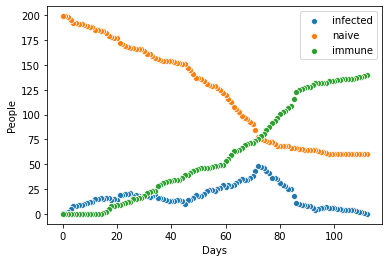

In [377]:
sns.scatterplot(data = df_infections, x = "days", y = "infected", label = "infected")
sns.scatterplot(data = df_infections, x = "days", y = "healthy", label = "naive")
sns.scatterplot(data = df_infections, x = "days", y = "immune", label = "immune")
plt.legend()
plt.ylabel("People")
plt.xlabel("Days")
plt.savefig("infections_over_time.png")
plt.show()

In [378]:
df_positions

x_position  y_position  status  day
0     45.559443   19.072475   naive    0
1      2.462008   27.001037   naive    0
2     40.532484   40.848680   naive    0
3     13.267225   39.204357   naive    0
4      0.476312   47.890958   naive    0
..          ...         ...     ...  ...
195    9.768617   28.592413  immune  112
196   46.997956   34.165573  immune  112
197    4.792815   28.142969  immune  112
198   16.472638   22.870507  immune  112
199    9.835567   29.161055  immune  112

[22600 rows x 4 columns]

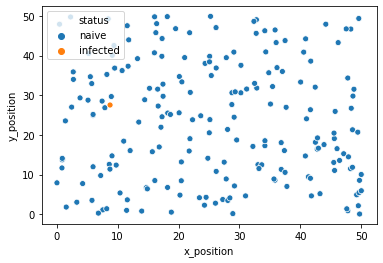

In [379]:
sns.scatterplot(data = df_positions[df_positions["day"] == 0], x = "x_position", y = "y_position", hue = "status")

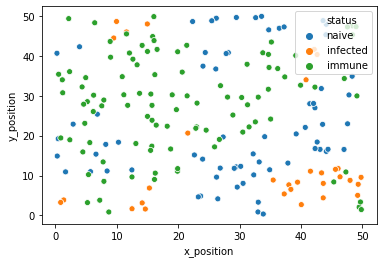

In [380]:
sns.scatterplot(data = df_positions[df_positions["day"] == min(80, last_day)], x = "x_position", y = "y_position", hue = "status")

In [381]:
import os

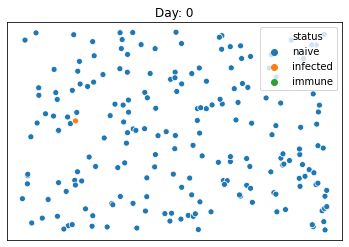

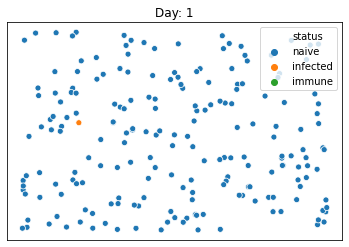

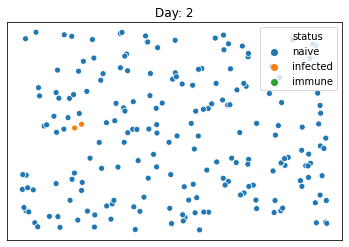

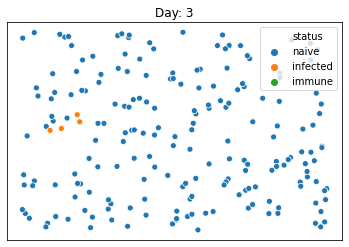

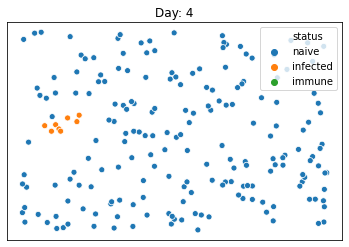

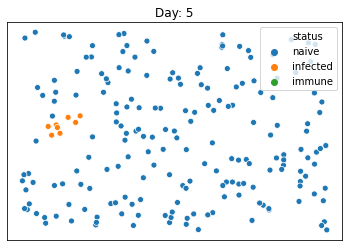

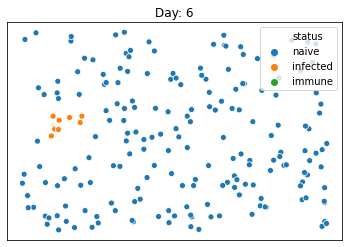

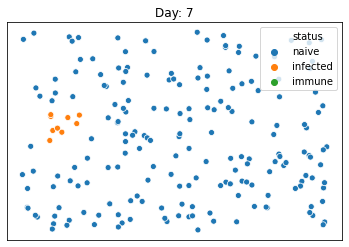

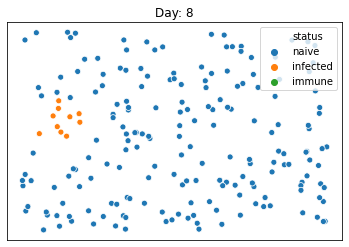

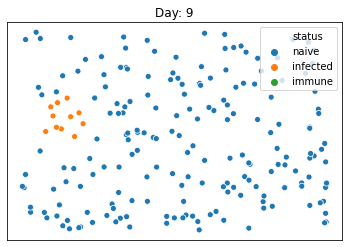

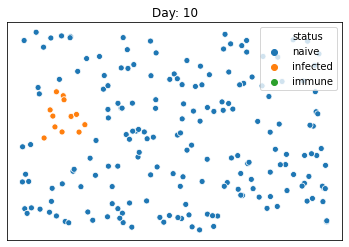

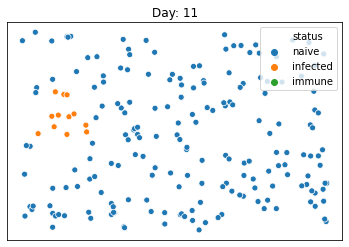

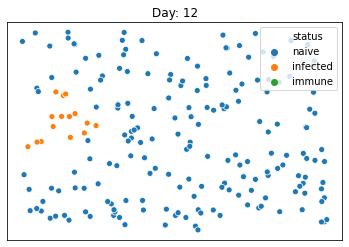

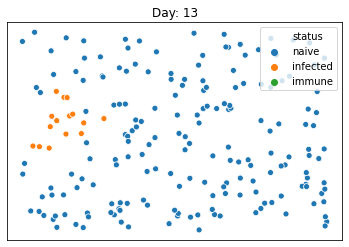

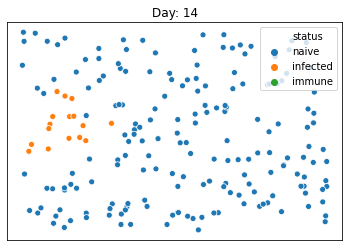

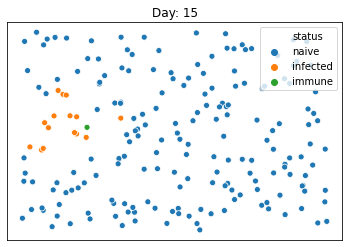

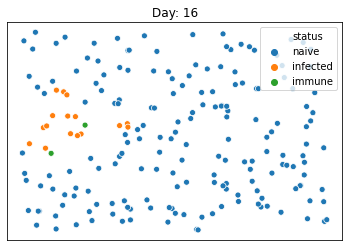

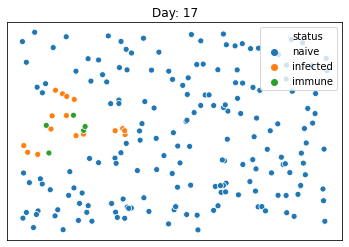

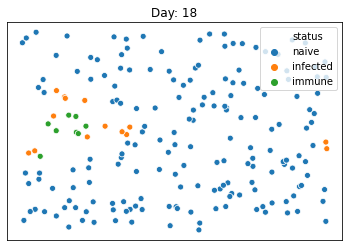

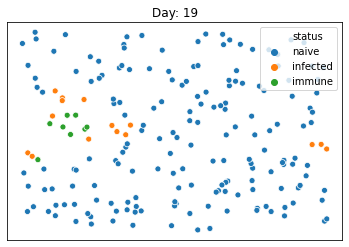

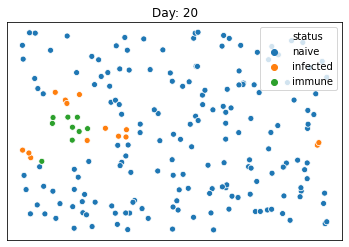

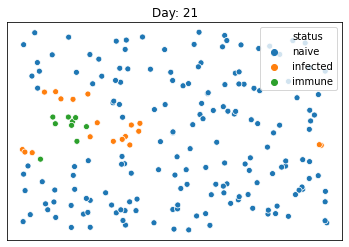

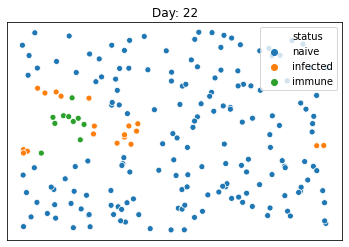

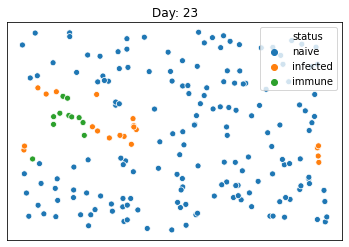

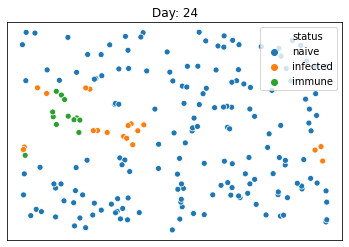

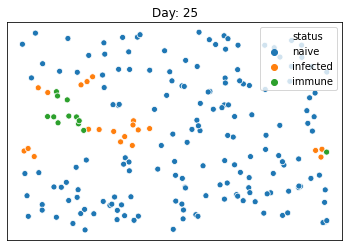

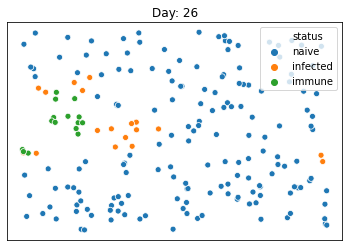

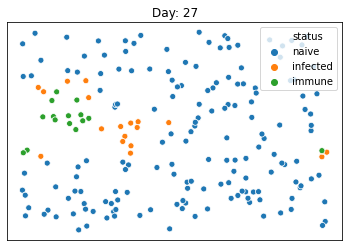

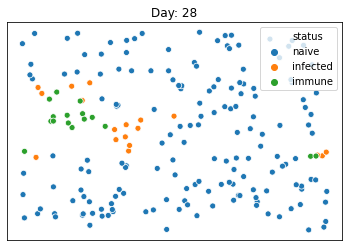

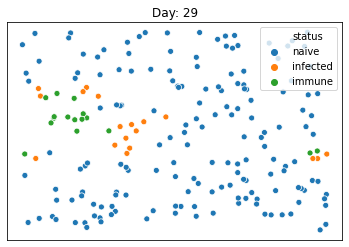

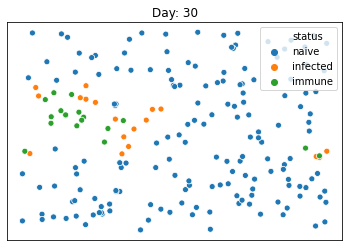

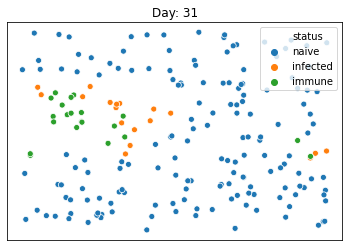

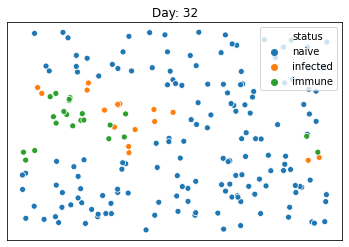

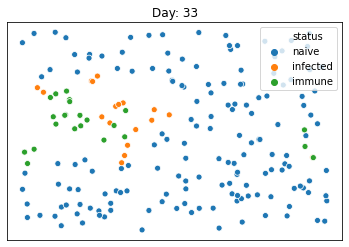

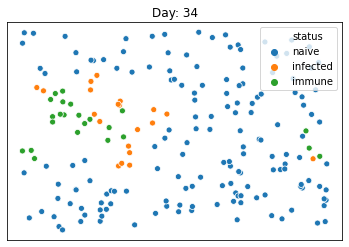

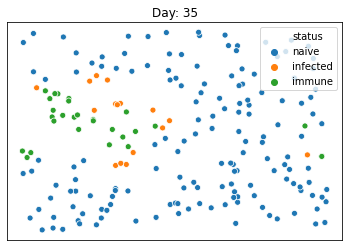

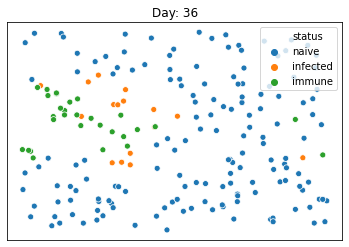

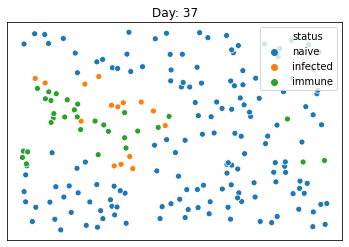

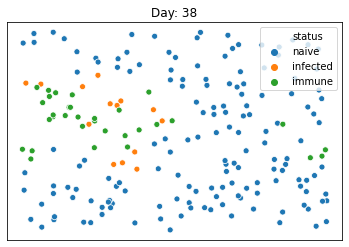

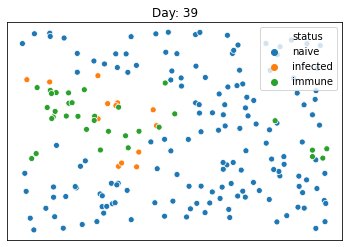

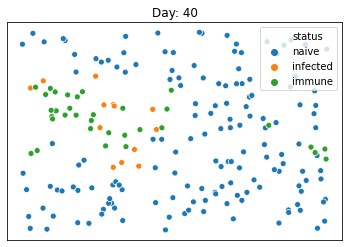

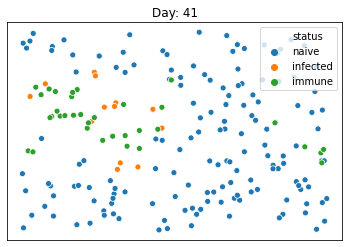

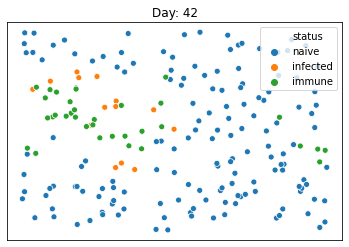

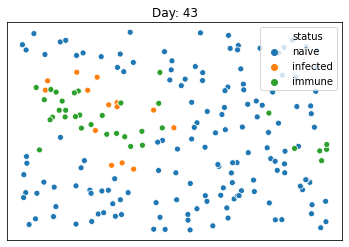

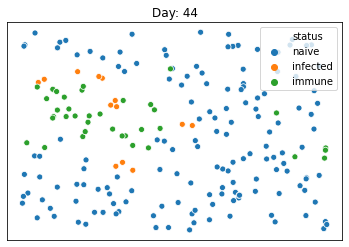

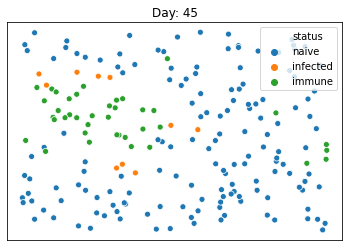

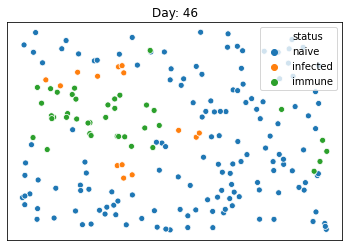

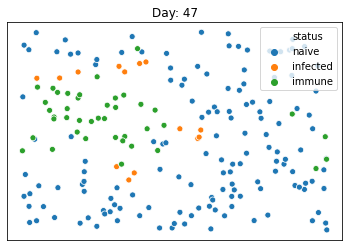

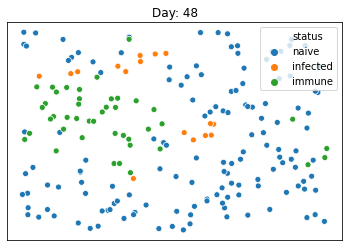

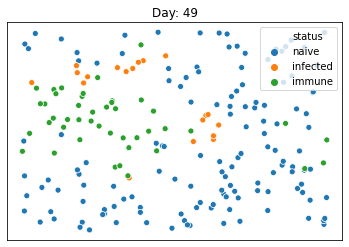

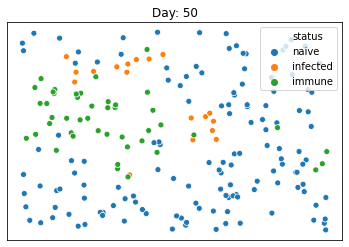

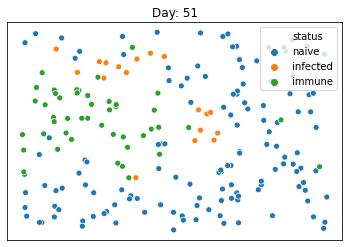

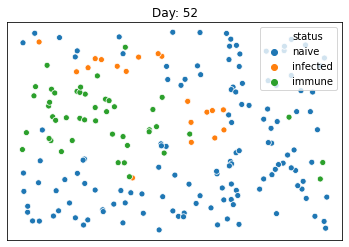

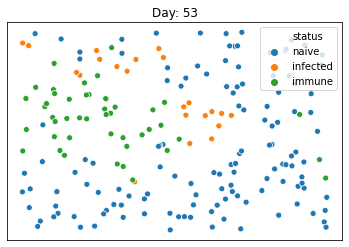

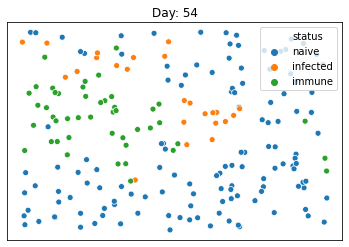

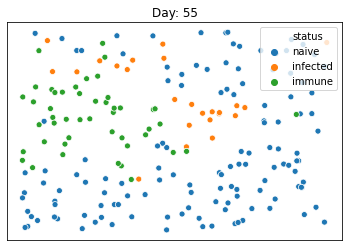

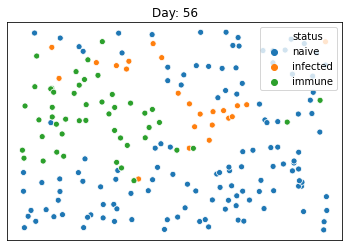

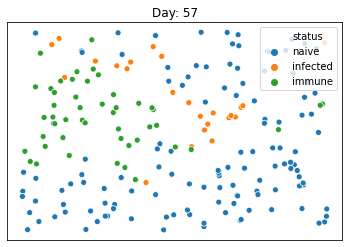

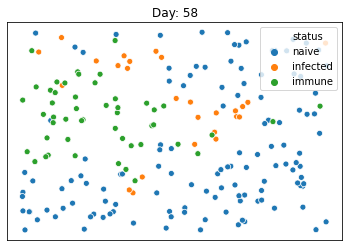

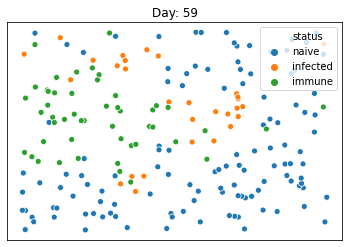

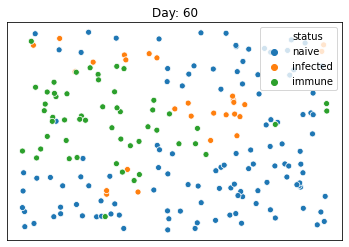

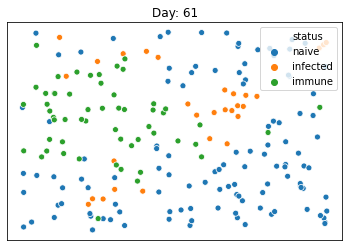

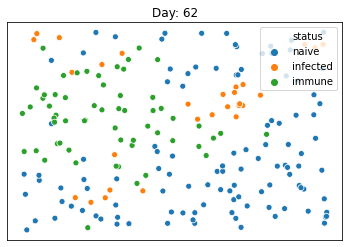

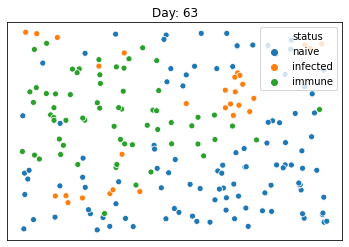

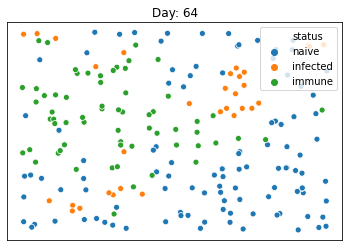

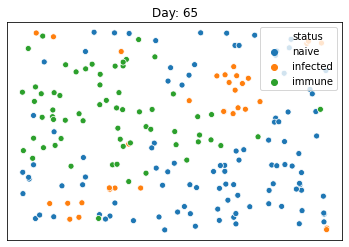

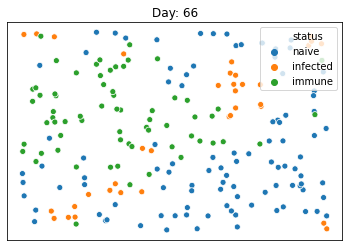

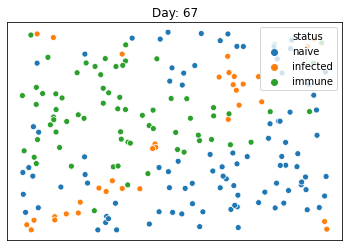

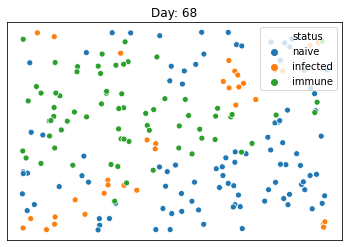

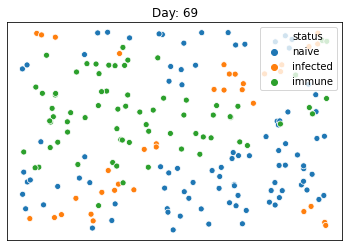

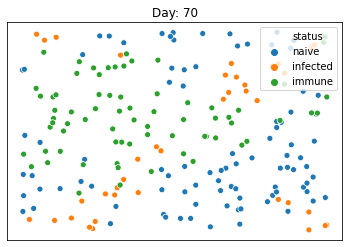

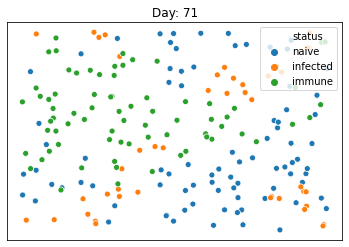

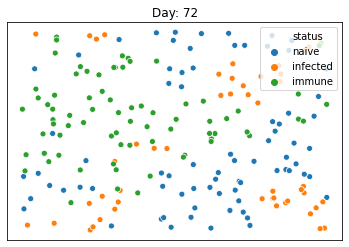

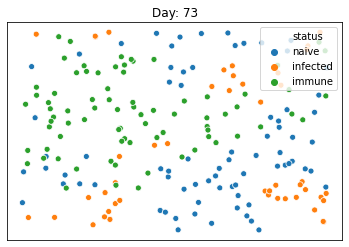

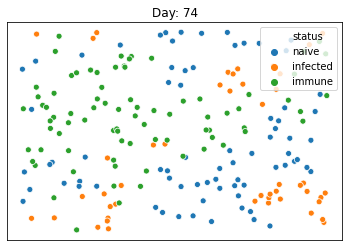

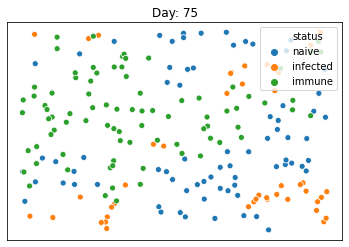

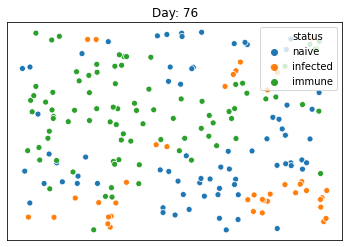

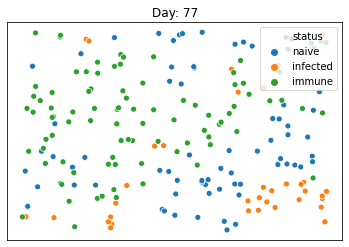

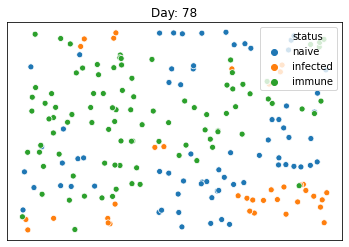

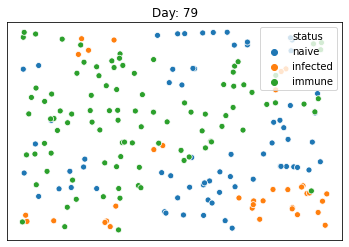

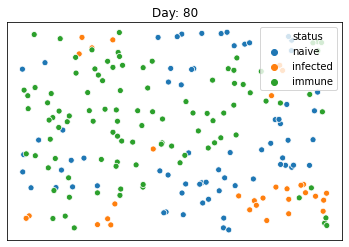

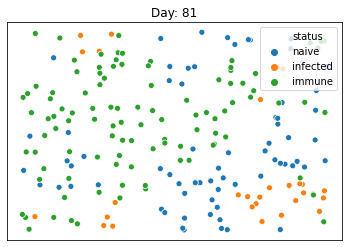

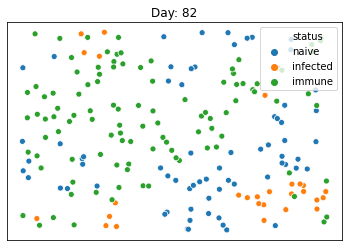

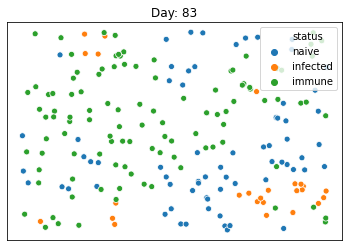

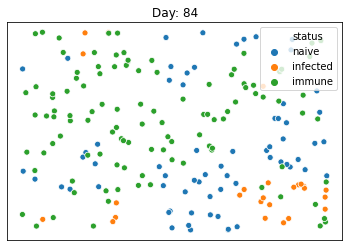

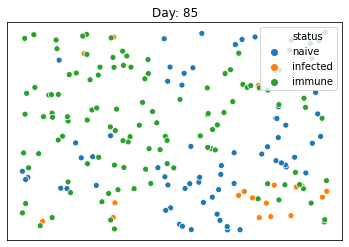

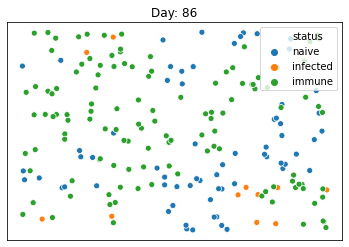

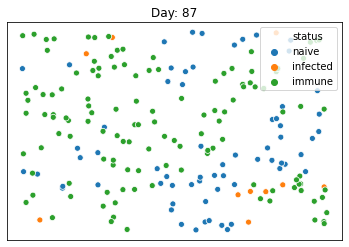

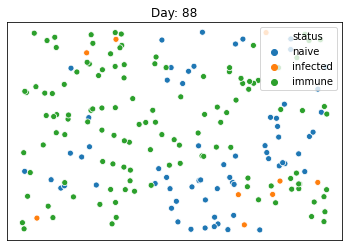

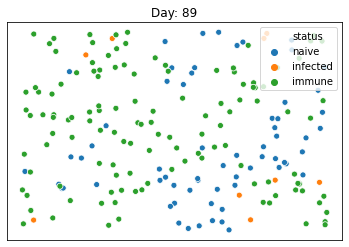

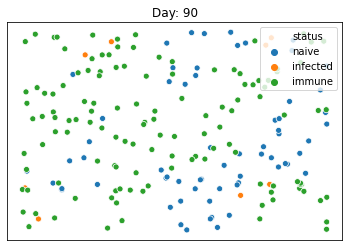

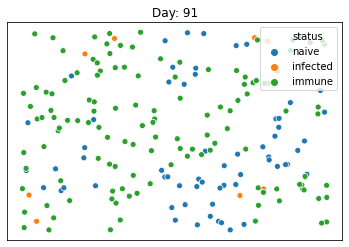

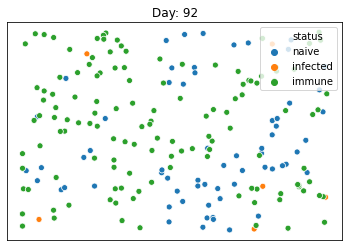

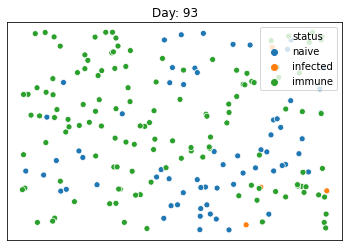

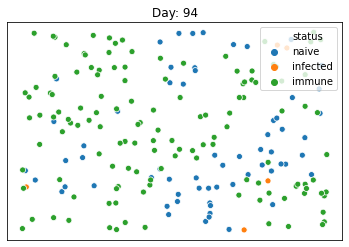

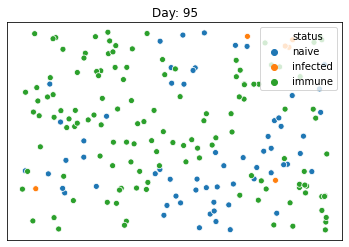

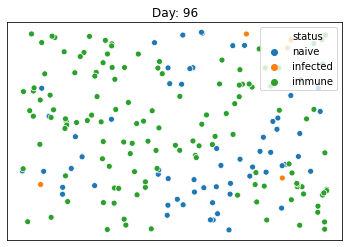

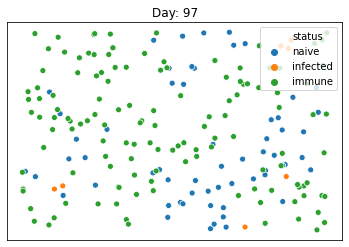

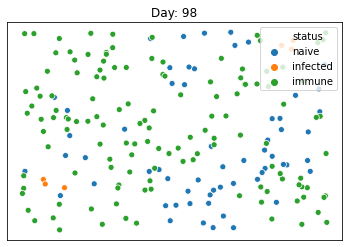

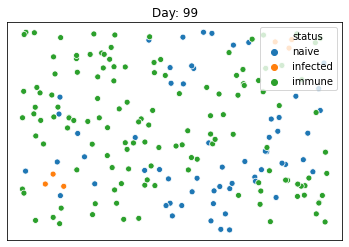

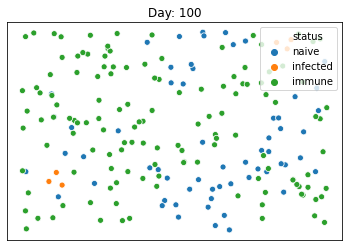

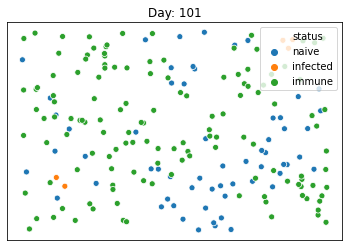

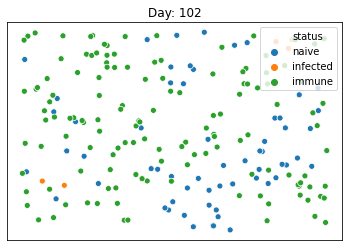

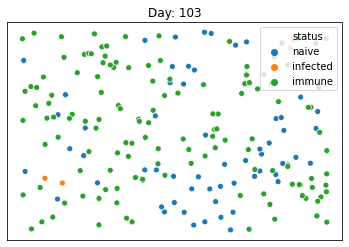

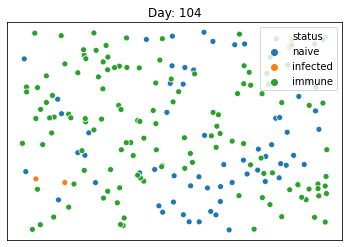

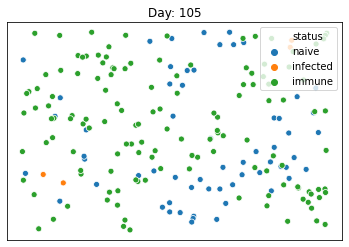

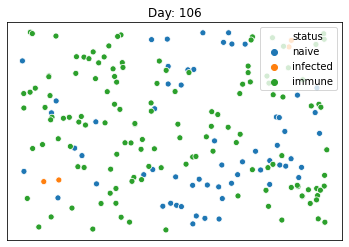

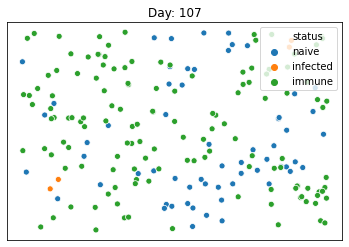

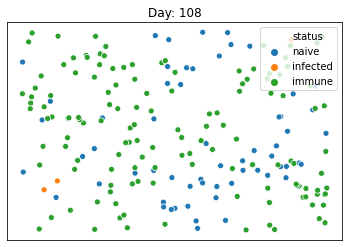

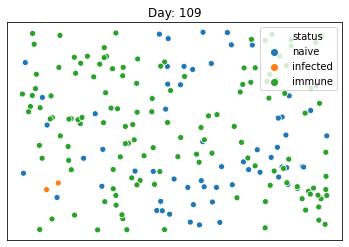

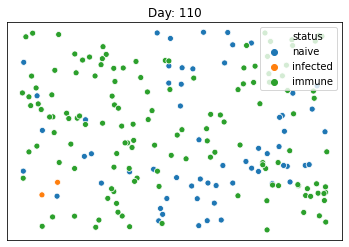

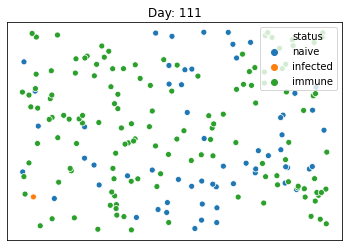

CPU times: user 41.5 s, sys: 9.69 s, total: 51.2 s
Wall time: 33.6 s


In [383]:
%%time
os.system("rm plots/*.png")
for day in range(0, min(365, last_day)):
    sns.scatterplot(data = df_positions[df_positions["day"] == day], x = "x_position", y = "y_position", hue = "status", hue_order = ["naive", "infected", "immune"])
    frame1 = plt.gca()
    for xlabel_i in frame1.axes.get_xticklabels():
        xlabel_i.set_visible(False)
        xlabel_i.set_fontsize(0.0)
    for xlabel_i in frame1.axes.get_yticklabels():
        xlabel_i.set_fontsize(0.0)
        xlabel_i.set_visible(False)
    for tick in frame1.axes.get_xticklines():
        tick.set_visible(False)
    for tick in frame1.axes.get_yticklines():
        tick.set_visible(False)
    plt.xlabel("")
    plt.ylabel("")
    num_infected = df_infections[df_infections["days"] == day].infected.iloc[0]
    plt.title(f"Day: {day}")
    plt.legend(loc=1)
    plt.savefig(f"plots/day_{day}.png")

    plt.show()

turn into gif

In [293]:
import glob
import moviepy.editor as mpy

In [384]:
%%time
gif_name = 'infections'
fps = 8
file_list = glob.glob('plots/*.png') # Get all the pngs in the current directory
list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
clip = mpy.ImageSequenceClip(file_list, fps=fps)
clip.write_gif('{}.gif'.format(gif_name), fps=fps)

t:   6%|▋         | 7/112 [00:00<00:01, 63.80it/s, now=None]

MoviePy - Building file infections.gif with imageio.


CPU times: user 2.48 s, sys: 46.9 ms, total: 2.53 s
Wall time: 2.57 s


view gif

In [95]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [136]:
from IPython.display import Image

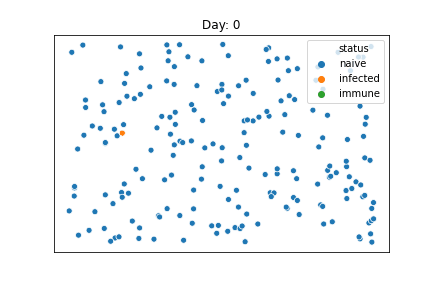

In [386]:
Image("infections.gif")